In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
plt.style.use('seaborn-whitegrid')
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import viridis, inferno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.preprocessing import StandardScaler

## Analysing Test Data 

In [90]:
df_train =  pd.read_csv('train.csv', nrows = 2_000_000, parse_dates=["pickup_datetime"])
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [91]:
df_train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

## Editing Data
* Deleting null statements and missing values  

In [92]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


In [93]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 2000000
New size: 1999923


In [94]:
print('Missing values in train data:')
display(df_train.isna().sum())

Missing values in train data:


key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

In [95]:
df_train.dropna(how = 'any', axis = 0, inplace = True)
# Shape of the df after dropping missing rows
print('Shape of the df after dropping missing rows:{}'.format(df_train.shape))

Shape of the df after dropping missing rows:(1999909, 8)


## Plotting the distribution of fare amount

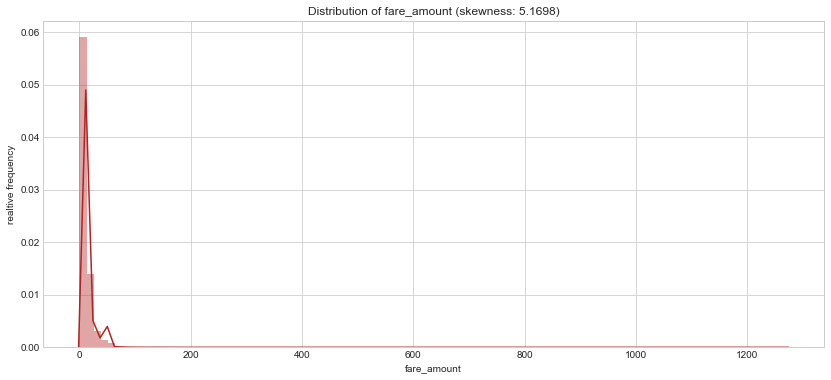

In [96]:
fig, ax = plt.subplots(figsize = (14,6))
#sns.distplot(df_train[df_train.fare_amount<100].fare_amount, bins = 100, color = 'firebrick', ax = ax) 
sns.distplot(df_train.fare_amount, bins = 100, color = 'firebrick', ax = ax)
ax.set_title('Distribution of fare_amount (skewness: {:0.5})'.format(df_train.fare_amount.skew()))
ax.set_ylabel('realtive frequency')
plt.show()

## The distribution of passangers

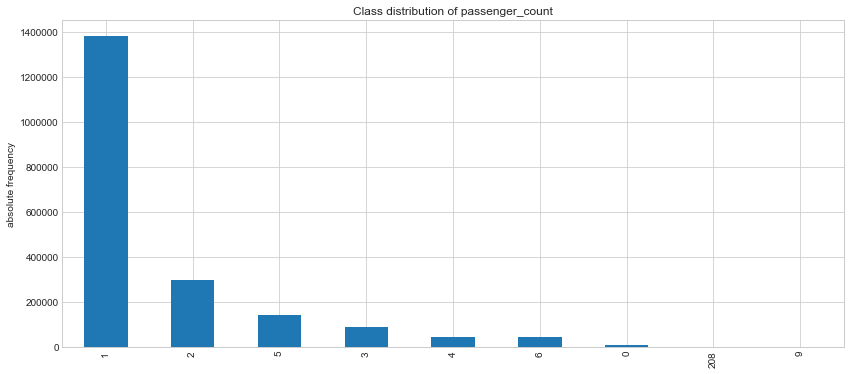

In [97]:
fig, ax = plt.subplots(figsize = (14,6))
class_dist = df_train.passenger_count.value_counts()
class_dist.plot(kind = 'bar', ax = ax)
ax.set_title('Class distribution of passenger_count')
ax.set_ylabel('absolute frequency')
plt.show()

## Test Data

In [113]:
df_test =  pd.read_csv('test.csv')
print('Missing values in test data:')
display(df_test.isna().sum())
df_test.head(5)
df_test.describe()

Missing values in test data:


key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


## Treating lon and lat values

In [99]:
def percentile(variable):
    two_and_half = variable.quantile(0.25)
    ninty_seven_half = variable.quantile(0.975)
    print('2.5 and 97.5 percentile of {} is respectively: {:0.2f}, and {:0.2f}'.format(variable.name, two_and_half, ninty_seven_half))
    
percentile(df_train.pickup_latitude)
percentile(df_train.dropoff_latitude)
percentile(df_train.pickup_longitude)
percentile(df_train.dropoff_longitude) 

2.5 and 97.5 percentile of pickup_latitude is respectively: 40.73, and 40.80
2.5 and 97.5 percentile of dropoff_latitude is respectively: 40.73, and 40.81
2.5 and 97.5 percentile of pickup_longitude is respectively: -73.99, and -73.78
2.5 and 97.5 percentile of dropoff_longitude is respectively: -73.99, and -73.78


In [100]:
df_train = df_train.loc[df_train.pickup_latitude.between(left = 40, right = 42), :]
df_train = df_train.loc[df_train.dropoff_latitude.between(left = 40, right = 42), :]

# For lons, our range is -75 to -72 degrees(with 40 and 42)
df_train = df_train.loc[df_train.pickup_longitude.between(left = -75, right = -72), :]
df_train = df_train.loc[df_train.dropoff_longitude.between(left = -75, right = -72), :]
print('Shape of train data after after dropping outliers from lats and lons: {}'.format(df_train.shape))

Shape of train data after after dropping outliers from lats and lons: (1958244, 8)


## Calculating Distance
* I am using Haversine formula https://en.wikipedia.org/wiki/Haversine_formula

In [101]:
def distance(lon1,lat1,lon2,lat2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

count    1.958244e+06
mean     2.069783e+00
std      2.360906e+00
min      0.000000e+00
25%      7.787699e-01
50%      1.337129e+00
75%      2.432140e+00
max      1.004671e+02
Name: distance_miles, dtype: float64

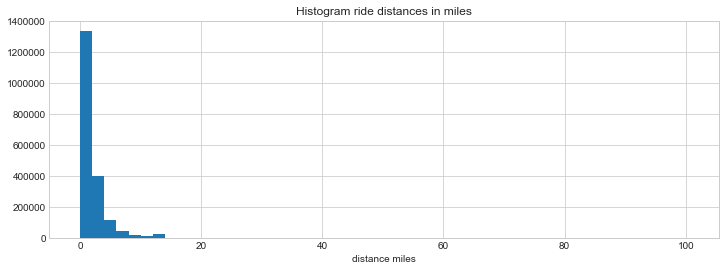

In [124]:
df_train['distance_miles'] = distance(df_train.pickup_longitude,df_train.pickup_latitude, \
                                       df_train.dropoff_longitude, df_train.dropoff_latitude,)
df_test['distance_miles'] = distance(df_test.pickup_longitude,df_test.pickup_latitude, \
                                       df_test.dropoff_longitude, df_test.dropoff_latitude,)
df_train.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
df_train.distance_miles.describe()

In [103]:
df_train.groupby('passenger_count')['distance_miles', 'fare_amount'].mean()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,distance_miles,fare_amount
passenger_count,,
0,1.732107,8.813325
1,2.041632,11.206037
2,2.180906,11.801086
3,2.101826,11.520995
4,2.134451,11.721259
5,2.073838,11.216190
6,2.123113,12.169197
9,8.106351,104.000000


In [104]:
df_train['abs_lon_diff'] = np.abs(df_train.pickup_longitude - df_train.dropoff_longitude)
df_train['abs_lat_diff'] = np.abs(df_train.pickup_latitude - df_train.dropoff_latitude)

In [105]:
print('Current Data Types:')
display(df_train.dtypes)

Current Data Types:


key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_miles                   float64
abs_lon_diff                     float64
abs_lat_diff                     float64
dtype: object

## Plotting Correlation 

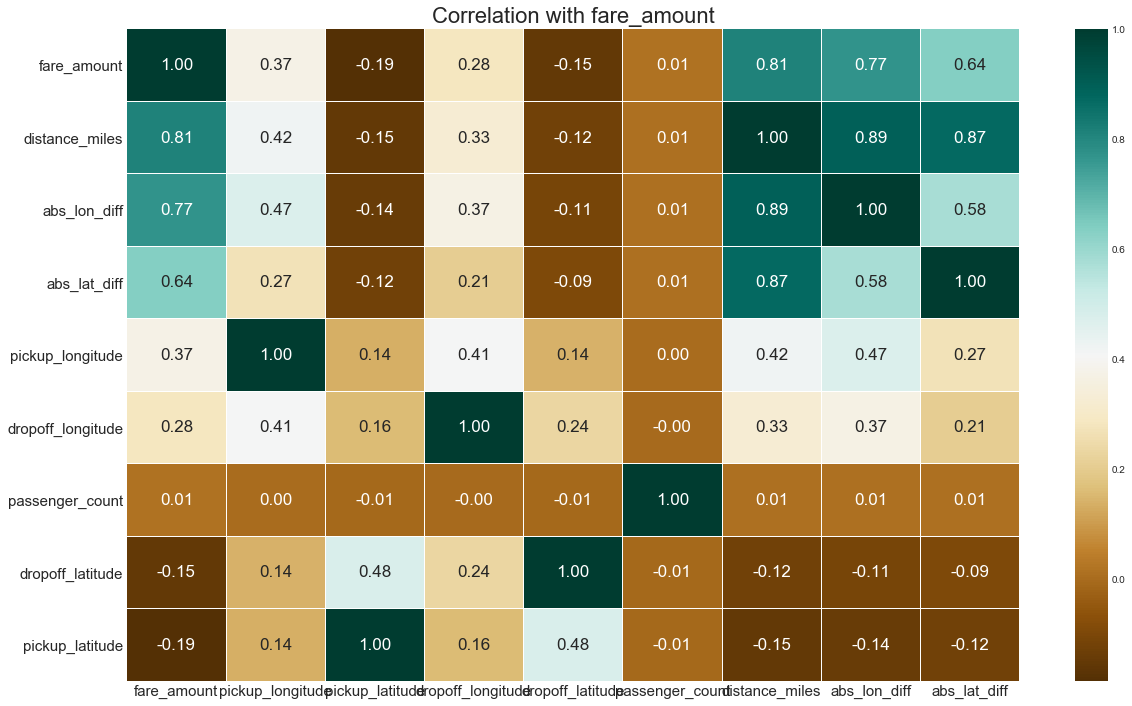

In [106]:
corr = df_train.corr().sort_values(by='fare_amount', ascending=False)
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(corr, annot = True, cmap ='BrBG', ax = ax, fmt='.2f', linewidths = 0.05, annot_kws = {'size': 17})
ax.tick_params(labelsize = 15)
ax.set_title('Correlation with fare_amount', fontsize = 22)
plt.show()

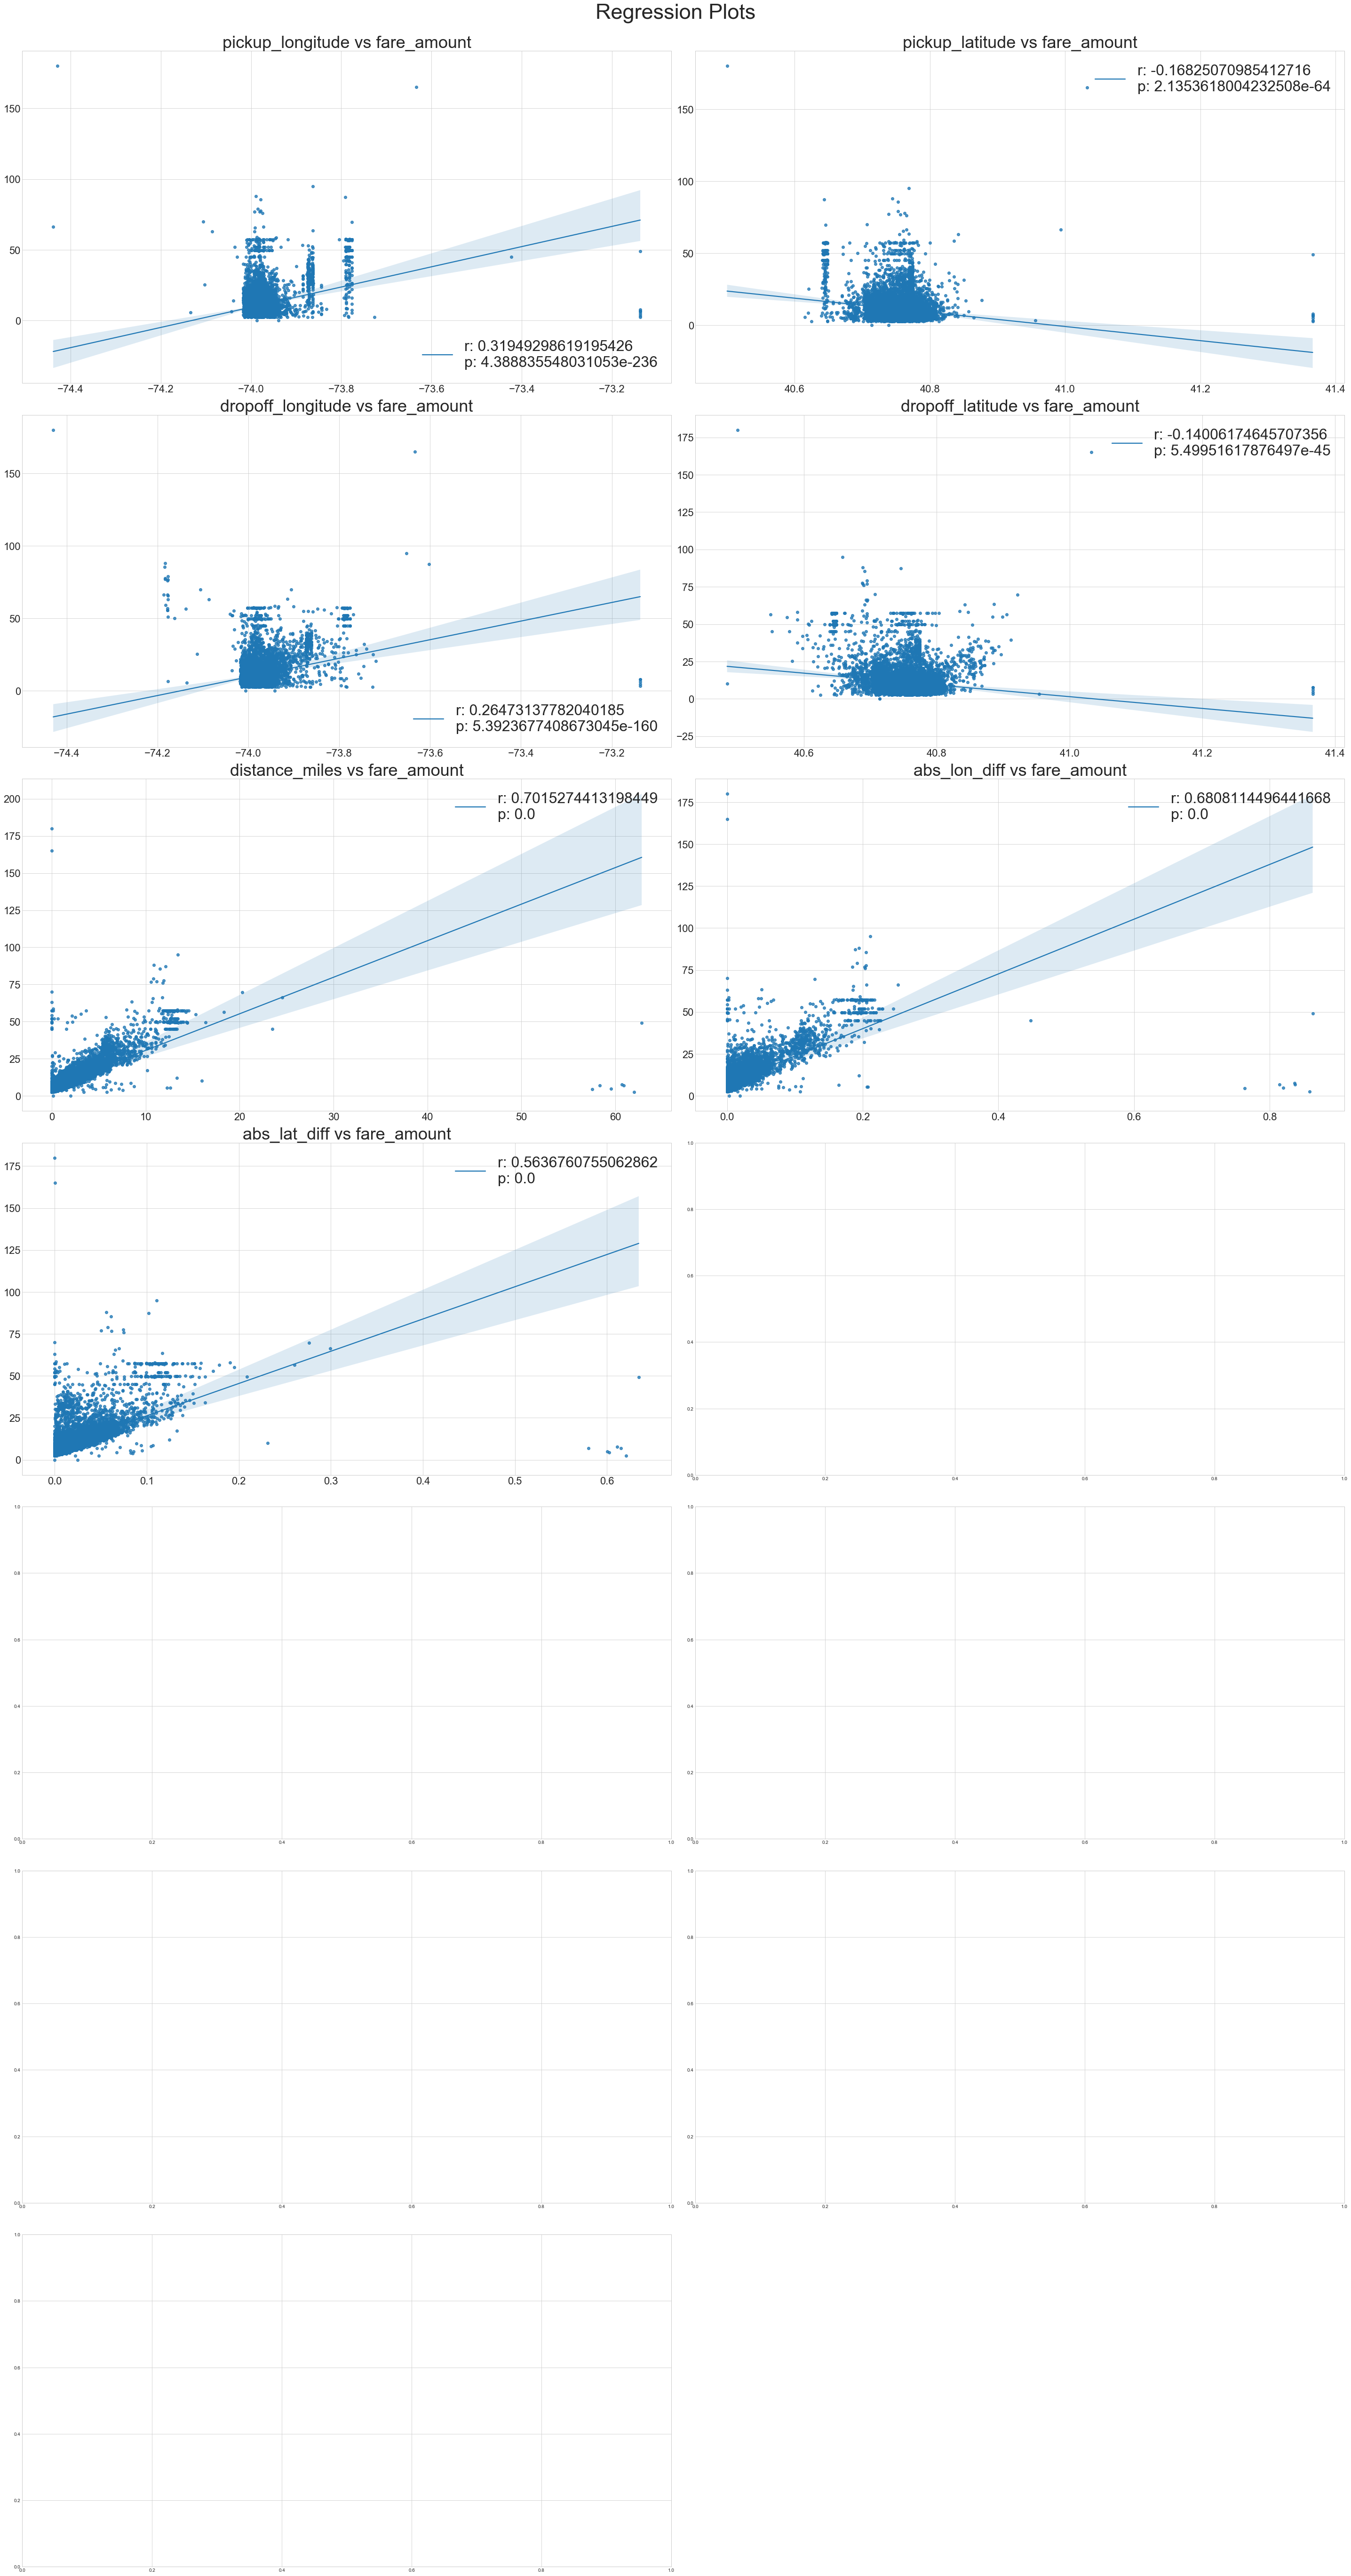

In [227]:
# Plot subplots of regression plots
continuous_var = df_train.iloc[0:10000, :].select_dtypes(include = ['float32', 'float64']).drop('fare_amount', axis = 1)
fig, axes = plt.subplots(7,2, figsize = (40,80))
for ax, column in zip(axes.flatten(), continuous_var.columns):
    x = continuous_var[column]
    y = df_train.fare_amount.iloc[0:10000]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    sns.regplot(x = continuous_var[column], y = y, ax = ax, line_kws={'label':'r: {}\np: {}'.format(r_value,p_value)})
    ax.set_title('{} vs fare_amount'.format(column), fontsize = 36)
    fig.suptitle('Regression Plots', fontsize = 45)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 22)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend(loc = 'best', fontsize = 32)
fig.delaxes(ax = axes[6,1])
fig.tight_layout(rect = [0, 0.03, 1, 0.97])

## Location visualization 

In [120]:
def plot_location(lon,lat, c_map):
    # Initial datashader visualization configuration
    pickup_range = dropoff_range = x_range, y_range = ((-74.05, -73.7), (40.6, 40.85))
    # Initiate canvas and create grid
    cvs = ds.Canvas(plot_width = 1080, plot_height = 600, x_range = x_range, y_range = y_range)
    agg = cvs.points(df_train, lon, lat)
    # Create image map with custom color map
    img = tf.shade(agg, cmap = c_map, how = 'eq_hist')
    return tf.set_background(img, 'black')

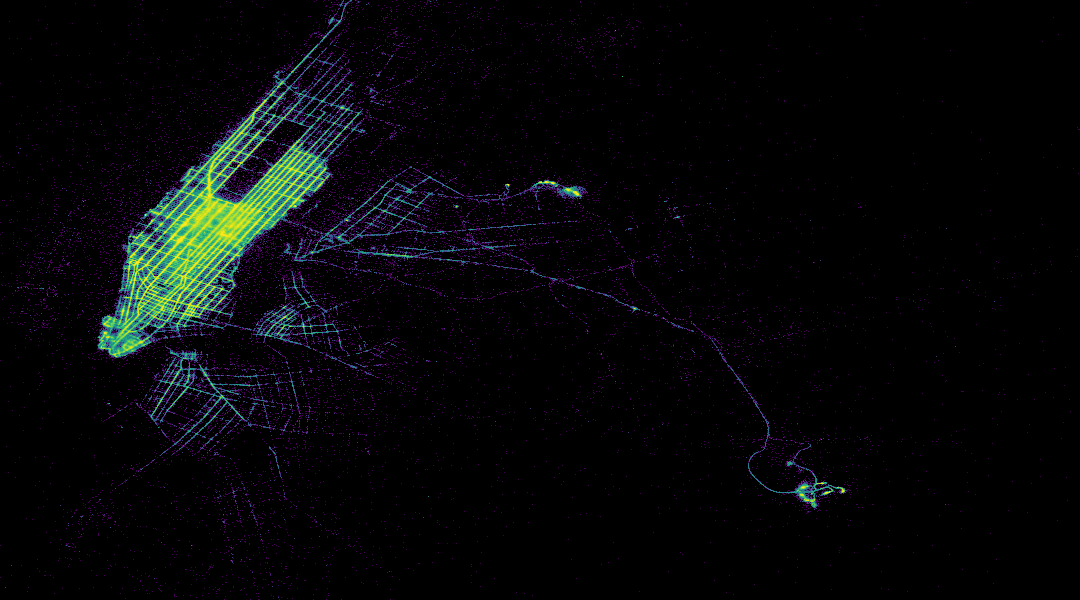

In [121]:
plot_location('pickup_longitude', 'pickup_latitude', viridis)

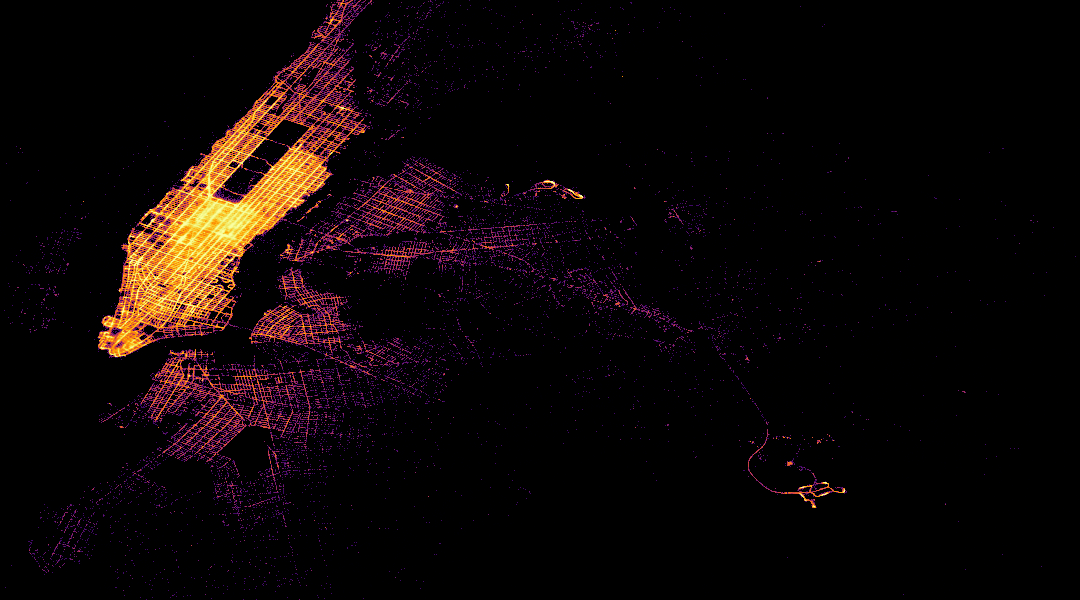

In [122]:
plot_location('dropoff_longitude', 'dropoff_latitude', inferno)

## Creating Linear Regression Models

### Basic Linear Regression

In [161]:
def split_datasets(X, y, test_size = 0.2):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test

In [162]:
def normalize(X):
    
    mean = np.mean(X)
    std = np.std(X)
    X_norm = (X - mean) / std
    return X_norm, mean, std

In [163]:
def prepare_X(X):

    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.array(X[:])
    X_new = np.column_stack((ones, X_new))
    return X_new

In [164]:
def hypothesis(X, theta):
    
    h_thetha = X.dot(theta);
    return h_thetha

In [165]:
def cost_function(X, y, theta):
   
    m = X.shape[0]
    J = 0
    if m == 0:
        return None
    else:
        J = np.sum(((hypothesis(X, theta) - y) ** 2))
        return J/(2*m)

In [166]:
def gradient_descent(X, y, theta, alpha, num_iters, print_J = True):
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        theta = theta -(1/m)*alpha*( X.T.dot((hypothesis(X, theta) - y)))
        
        #theta = theta - alpha / m * ((hypothesis(X, theta) - y))
        J = cost_function(X, y, theta)
        ######################
        if print_J == True:
            print(J)
        J_history.append(J)
    return theta, J_history

In [167]:
def plot_data(X_train, X_test, y_train, y_test):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train['distance_miles'],X_train['passenger_count'],y_train,c='green', marker='o', alpha=0.5)
    ax.scatter(X_test['distance_miles'],X_test['passenger_count'],y_test,c='red', marker='o', alpha=0.5)
    plt.show()

In [168]:
features = ['distance_miles', 'passenger_count']
X = df_train[features].values
y = df_train['fare_amount'].values

In [169]:
X_train, X_test, y_train, y_test = split_datasets(X, y, 0.2)
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(1566595, 2), y=(1566595,)
Test set: X=(391649, 2), y=(391649,)


In [170]:
#plot_data(X_train, X_test, y_train, y_test)

In [171]:
X_train_norm, mean, std = normalize(X_train)
X = prepare_X(X_train_norm)
theta = np.array([0, 0, 0])
y = y_train[:]

In [172]:
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
print(cost_function(X, y, theta))

X: (1566595, 3)
y: (1566595,)
111.73018650228676


In [173]:
alpha = 0.02
num_iters = 1500

In [174]:
new_theta, Js = gradient_descent(X, y, theta, alpha, num_iters, False)
print('Theta 0: {}; Theta 1: {}; Thetha 3: {};'.format(new_theta[0], new_theta[1], new_theta[2]))

Theta 0: 10.697461682048957; Theta 1: 6.422787865135986; Thetha 3: 0.07579159228887977;


In [175]:
X_test_proc = prepare_X((X_test - mean)/std)
y_test_pred = hypothesis(X_test_proc, new_theta)
rel_diff = np.abs(np.divide(y_test - y_test_pred, y_test)) *100
diff = np.abs(y_test_pred - y_test)
res = pd.DataFrame({'y_actual' : y_test, 'y_pred' : y_test_pred, 'err' : rel_diff})
print(res)

        y_actual     y_pred        err
0          13.00   7.939828  38.924403
1           7.00   7.671091   9.587020
2           4.10   6.440760  57.091700
3          20.00  16.344031  18.279846
4           9.00   6.941519  22.872015
...          ...        ...        ...
391644     30.83  21.288313  30.949357
391645      6.50   7.401694  13.872211
391646      9.70  12.910572  33.098683
391647      5.30   8.110517  53.028625
391648      5.00   7.409372  48.187443

[391649 rows x 3 columns]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## Errors Evaluation 

In [176]:
rms = sqrt(mean_squared_error(y_test, y_test_pred))
mse = mean_squared_error(y_test, y_test_pred) 
mae = mean_absolute_error(y_test, y_test_pred)
print("RMSE: ", rms)
print("MSE: ", mse)
print("MAE: ", mae)

RMSE:  5.607448928673278
MSE:  31.443483487679085
MAE:  2.5601856846848494


### Sklearn Linear Regression 

In [225]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
r_squared = linear_reg.score(X_train,y_train)
print("R^2: ", r_squared);

R^2:  0.6598769668704688


### Comparing results 

In [224]:
res = pd.DataFrame({'y_pred' : y_test_pred,  'y_pred Sklearn' : y_pred})
print(res)

         y_pred  y_pred Sklearn
0      9.210500        9.205235
1      9.422778        9.417781
2      5.666139        5.656408
3      8.457338        8.451124
4     15.581420       15.584182
...         ...             ...
9909   8.995448        8.999083
9910  11.378469       11.385106
9911  44.465572       44.513897
9912  21.925518       21.945445
9913   7.032530        7.033692

[9914 rows x 2 columns]
